In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
import datetime

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 25.8 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


# Custom Functions

In [38]:
def create_channel_mappings(media, impressions):
    """
    Generate mapping dictionaries for media spend and impressions columns.

    Parameters:
        media (list of str): List of column names with spend/cost data.
                             Expected to have columns ending with '_cost'.
        impressions (list of str): List of column names with impressions data.
                                   Expected to have columns ending with '_cost_impressions'.

    Returns:
        tuple: Two dictionaries:
            - correct_media_spend_to_channel: Mapping of cost column names to simplified channel names.
            - correct_media_to_channel: Mapping of impressions column names to simplified channel names.
    """
    correct_media_spend_to_channel = {}
    for col in media:
        if col.endswith("_cost"):
            channel_name = col[:-len("_cost")]
        else:
            channel_name = col
        correct_media_spend_to_channel[col] = channel_name

    correct_media_to_channel = {}
    for col in impressions:
        if col.endswith("_impressions"):
          #substitute
            channel_name = col[:-len("_impressions")]
        else:
            channel_name = col
        correct_media_to_channel[col] = channel_name

    return correct_media_spend_to_channel, correct_media_to_channel

# Raw Data

In [39]:
# Assuming your CSV file is in the 'MyDrive' folder
file_path = 'mmm_train_all_phase2.csv'
#file_path = 'training_data_linkedin_backfill.csv'
# Read the CSV file into a pandas DataFrame
raw_data = pd.read_csv(file_path)

print(raw_data.shape)
raw_data = raw_data.drop_duplicates()
print(raw_data.shape)


(335, 51)
(335, 51)


In [40]:
raw_data['total_s'] = raw_data['gift_spend'] + raw_data['linkedin_spend']  + raw_data['event_spend'] + raw_data['googleAds_spend'] 

In [41]:
raw_data['total_s'].mean()

np.float64(17220.064205855382)

In [42]:
folder_path = "data/usaonlyanalysis"
event_dates = pd.read_csv(folder_path + '/' + 'event_list.csv')
event_dates['find_date'] = event_dates['name'].apply(lambda x: x.find('20'))
event_dates=event_dates[event_dates['find_date']>0]
event_dates['datestr']=event_dates[['name','find_date']].apply(lambda x: x['name'][x['find_date']:x['find_date']+10], axis=1)
event_dates['datestr'] = event_dates['datestr'].apply(lambda x: x.replace("-",""))
event_dates['datestr'] = event_dates['datestr'].apply(lambda x: x.replace(" ",""))
event_dates['datestr'] = event_dates['datestr'].apply(lambda x: x[:8])
event_dates['date'] = event_dates['datestr'].apply(lambda x: str(datetime.datetime.strptime(str(x), "%Y%m%d").date()))
event_dates['event_hosted'] = 1
event_dates = event_dates[['date', 'event_hosted']].groupby('date').sum().reset_index()

In [43]:
event_dates

,date,event_hosted
0,2024-01-15,1
1,2024-01-16,1
2,2024-02-26,1
3,2024-04-10,1
4,2024-05-08,1
5,2024-06-17,1
6,2024-06-18,2
7,2024-07-29,1
8,2024-10-09,1
9,2024-10-28,1


In [44]:
events_raw = pd.read_csv(folder_path + '/' + 'EventsDataAgg - usonly.csv')

In [45]:
folder_path = "data/usaonlyanalysis"
webinar_pt2 = pd.read_csv(folder_path + '/' + 'webinar_part2.csv')
webinar = pd.read_csv(folder_path + '/' + 'webinar_dates.csv')
webinar = pd.concat([webinar,webinar_pt2])

webinar['find_date'] = webinar['name'].apply(lambda x: x.find('20'))
webinar=webinar[webinar['find_date']>0]
webinar['datestr']=webinar[['name','find_date']].apply(lambda x: x['name'][x['find_date']:x['find_date']+8], axis=1)
webinar = webinar[webinar['datestr']!='2024 web']
webinar['date'] = webinar['datestr'].apply(lambda x: str(datetime.datetime.strptime(str(x), "%Y%m%d").date()))
webinar['webinar_occured'] = 1
webinar = webinar[['date', 'webinar_occured']].groupby('date').sum().reset_index()


In [46]:
dates_exclude = raw_data[raw_data['event_spend']>0]
dates_exclude = dates_exclude['date'].to_list()
event_dates = event_dates[event_dates['date'].isin(dates_exclude)==False]
raw_data = pd.merge(raw_data, event_dates[['date', 'event_hosted']], on='date', how='left')
raw_data['event_hosted'] = raw_data['event_hosted'].fillna(0)
print(raw_data.shape[0])

raw_data = pd.merge(raw_data, webinar[['date', 'webinar_occured']], on='date', how='left')
raw_data['webinar_occured'] = raw_data['webinar_occured'].fillna(0)
print(raw_data.shape[0])

335
335


In [47]:
# Assuming your DataFrame has a date column called 'date'
df = raw_data.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Find gaps larger than 1 day
df['date_diff'] = df['date'].diff().dt.days
non_sequential = df[df['date_diff'] > 1]
print(non_sequential)

Empty DataFrame
Columns: [Unnamed: 0, model_week, date, iso_week, iso_year, ga4_sessions, refined_ga4_ressions, podcast_streams, linkedin_spend, linkedin_impressions, linkedin_clicks, linkedin_spend_demandgen, linkedin_leads, lead_conv_rate, converted_leads, non_lead_gen, gSearch_sessions, gSearch_impressions, gift_spend, email_opened_cnt, direct_spend, direct_spend_pharios, direct_spend_dc360, fb_spend, fb_impressions, fb_clicks, googleAds_spend, googleAds_impressions, event_spend, all_mql_count, linkedin_mql_count, sales_sourced_mql_cnt, pharios_mql_cnt, dc360_mql_count, dc360_mql_count.1, impactDotCom_ga4_sessions, sum_content_download, sum_blog_subscribers, sum_newsletter_signup, month, daily_avg_queries, inflation_rate, durable_goods_rates, week, WEI, all_less_linkedin_mql, averageMQL_linkedin, smoothed_MQL_linkedin, smoothed_linkedin_MQL_all, averageMQL, smoothed_MQL, total_s, event_hosted, webinar_occured, date_diff]
Index: []

[0 rows x 55 columns]


In [48]:
raw_data['marketoDivLinkedinLeads'] = raw_data['linkedin_mql_count']/raw_data['linkedin_leads']
raw_data['7_day_mql_marketoDivLinkedinLeads'] = raw_data['marketoDivLinkedinLeads'].rolling(window=7).mean()
raw_data['7_day_mql_marketoDivLinkedinLeads'] = raw_data['7_day_mql_marketoDivLinkedinLeads'].fillna(raw_data['7_day_mql_marketoDivLinkedinLeads'].mean())

In [49]:
raw_data['7_day_mql_marketoDivLinkedinLeads'].median()

np.float64(0.36246740392985866)

In [50]:
raw_data.columns

Index(['Unnamed: 0', 'model_week', 'date', 'iso_week', 'iso_year',
       'ga4_sessions', 'refined_ga4_ressions', 'podcast_streams',
       'linkedin_spend', 'linkedin_impressions', 'linkedin_clicks',
       'linkedin_spend_demandgen', 'linkedin_leads', 'lead_conv_rate',
       'converted_leads', 'non_lead_gen', 'gSearch_sessions',
       'gSearch_impressions', 'gift_spend', 'email_opened_cnt', 'direct_spend',
       'direct_spend_pharios', 'direct_spend_dc360', 'fb_spend',
       'fb_impressions', 'fb_clicks', 'googleAds_spend',
       'googleAds_impressions', 'event_spend', 'all_mql_count',
       'linkedin_mql_count', 'sales_sourced_mql_cnt', 'pharios_mql_cnt',
       'dc360_mql_count', 'dc360_mql_count.1', 'impactDotCom_ga4_sessions',
       'sum_content_download', 'sum_blog_subscribers', 'sum_newsletter_signup',
       'month', 'daily_avg_queries', 'inflation_rate', 'durable_goods_rates',
       'week', 'WEI', 'all_less_linkedin_mql', 'averageMQL_linkedin',
       'smoothed_MQL_li

In [75]:
case= raw_data[['linkedin_spend', 'googleAds_spend', 'fb_spend',  'direct_spend']]
case.sum()

linkedin_spend     3.841928e+06
googleAds_spend    1.568981e+06
fb_spend           6.795169e+05
direct_spend       1.061271e+06
dtype: float64

In [51]:
example = raw_data[(raw_data['direct_spend_dc360']>0) | (raw_data['dc360_mql_count']>0)]
example [['model_week', 'date','direct_spend_dc360', 'dc360_mql_count' ]]

,model_week,date,direct_spend_dc360,dc360_mql_count
7,202416,2024-04-18,0.0,1
35,202420,2024-05-16,7950.0,0
74,202426,2024-06-24,0.0,20
85,202427,2024-07-05,0.0,6
91,202428,2024-07-11,0.0,2
98,202429,2024-07-18,7950.0,0
119,202432,2024-08-08,0.0,1
124,202433,2024-08-13,0.0,2
130,202434,2024-08-19,0.0,22
145,202436,2024-09-03,0.0,1


In [52]:
example = raw_data[(raw_data['direct_spend_pharios']>0) | (raw_data['pharios_mql_cnt']>0)]
example [['model_week', 'date','direct_spend_pharios', 'pharios_mql_cnt' ]]

,model_week,date,direct_spend_pharios,pharios_mql_cnt
125,202433,2024-08-14,50000.0,0
147,202436,2024-09-05,0.0,54
148,202436,2024-09-06,0.0,145
154,202437,2024-09-12,0.0,2
168,202439,2024-09-26,0.0,1
309,202507,2025-02-14,200000.0,0
326,202510,2025-03-03,0.0,181
328,202510,2025-03-05,0.0,2
333,202511,2025-03-10,0.0,61


In [53]:
raw_data['smoothed_all_mql'] = raw_data['smoothed_MQL']

raw_data['scaled_linkedin_leads_20P'] = raw_data['linkedin_leads'].apply(lambda x: int(np.round(x*0.20,0)))
raw_data['scaled_linkedin_leads_30P'] = raw_data['linkedin_leads'].apply(lambda x: int(np.round(x*0.30,0)))
raw_data['scaled_linkedin_leads_mql_20P'] = raw_data['all_mql_count'] - raw_data['linkedin_mql_count'] + raw_data['scaled_linkedin_leads_20P']
raw_data['scaled_linkedin_leads_mql_30P'] = raw_data['all_mql_count'] - raw_data['linkedin_mql_count'] + raw_data['scaled_linkedin_leads_30P']

raw_data['scaled20_leads_mql_lesspharios'] = raw_data['all_mql_count'] - raw_data['linkedin_mql_count'] + raw_data['scaled_linkedin_leads_20P']- raw_data['pharios_mql_cnt']
raw_data['direct_lesspharios_spend'] = raw_data['direct_spend'] - raw_data['direct_spend_pharios'] 

raw_data['scaled20_leads_mql_lesspharios_lessBDE'] = raw_data['all_mql_count'] - raw_data['linkedin_mql_count'] + raw_data['scaled_linkedin_leads_20P']- raw_data['pharios_mql_cnt'] - raw_data['sales_sourced_mql_cnt']
raw_data['scaled20_leads_mql_lesspharios_lessBDE_lessDC'] = raw_data['all_mql_count'] - raw_data['linkedin_mql_count'] + raw_data['scaled_linkedin_leads_20P']- raw_data['pharios_mql_cnt'] - raw_data['sales_sourced_mql_cnt'] - raw_data['dc360_mql_count']
raw_data['direct_lessbulk_spend'] = raw_data['direct_spend'] - raw_data['direct_spend_pharios']  - raw_data['direct_spend_dc360'] 


raw_data['scaled20_leads_mql_lesspharios_lessBDE_lessDC'] = raw_data['all_mql_count'] - raw_data['linkedin_mql_count'] + raw_data['scaled_linkedin_leads_mql_20P']- raw_data['pharios_mql_cnt'] - raw_data['sales_sourced_mql_cnt'] - raw_data['dc360_mql_count']
raw_data['scaled30_leads_mql_lesspharios_lessBDE_lessDC'] = raw_data['all_mql_count'] - raw_data['linkedin_mql_count'] + raw_data['scaled_linkedin_leads_mql_30P']- raw_data['pharios_mql_cnt'] - raw_data['sales_sourced_mql_cnt'] - raw_data['dc360_mql_count']


In [54]:
# Baseline
# 20P
# 20P - Pharios
# 20P - Pharios -BDE
# 20P - Pharios -BDE - DC360

# Model Specs

In [55]:
try:
    print(models_dict)
except:
    models_dict = {}
    output_dict = {}

{'baseline': {'response_var': 'smoothed_MQL', 'df_variables': ['date', 'podcast_streams', 'linkedin_spend', 'gSearch_sessions', 'gift_spend', 'email_opened_cnt', 'direct_spend', 'fb_spend', 'googleAds_spend', 'event_spend', 'smoothed_MQL', 'refined_ga4_ressions'], 'organic_variables': ['podcast_streams', 'email_opened_cnt', 'refined_ga4_ressions'], 'control_variables': ['gSearch_sessions'], 'roi_m_vars': {'linkedin_spend': (0.3, 0.3), 'gift_spend': (0.01, 0.4), 'direct_spend': (0.01, 0.4), 'fb_spend': (0.1, 0.3), 'googleAds_spend': (0.1, 0.25), 'event_spend': (0.01, 0.1)}, 'knots': 3, 'max_lag': 6, 'sample_size_prior': 500}, 'scaled30_leads_mql_lesspharios_lessBDE_lessDC_plus_marketo': {'response_var': 'scaled30_leads_mql_lesspharios_lessBDE_lessDC', 'df_variables': ['date', 'podcast_streams', 'linkedin_spend', 'gSearch_sessions', 'gift_spend', 'email_opened_cnt', 'direct_lessbulk_spend', 'fb_spend', 'googleAds_spend', 'event_spend', 'refined_ga4_ressions', 'event_hosted', 'webinar_occ

In [56]:
output_dict

{}

In [57]:
df_vars = ['date', 'podcast_streams', 'linkedin_spend', 'gSearch_sessions', 'gift_spend', 'email_opened_cnt', 
           'direct_spend','fb_spend','googleAds_spend','event_spend','smoothed_MQL', 'refined_ga4_ressions']
organic_vars =  ['podcast_streams', 'email_opened_cnt', 'refined_ga4_ressions']
control_vars = ['gSearch_sessions']
  
roi_m_vars = {'linkedin_spend': (0.30, 0.3),
  'gift_spend': (0.01, 0.4),
  'direct_spend': (0.01, 0.4),
  'fb_spend' : (0.10, 0.3),
  'googleAds_spend': (0.10, 0.25),
  'event_spend' :(0.01, 0.1)}
knots = 3
max_lag = 6
sample_size_prior = 500

baseline = {'response_var': 'smoothed_MQL', 'df_variables':df_vars, 'organic_variables' : organic_vars, 'control_variables': control_vars, 'roi_m_vars':roi_m_vars, 'knots':knots, 'max_lag': max_lag, 'sample_size_prior':sample_size_prior}  

models_dict['baseline']=baseline

In [58]:
df_vars = ['date', 'podcast_streams', 'linkedin_spend', 'gSearch_sessions', 'gift_spend', 'email_opened_cnt', 
           'direct_lessbulk_spend','fb_spend','googleAds_spend','event_spend','refined_ga4_ressions', 'event_hosted', 'webinar_occured', 
           'smoothed_MQL', 'scaled30_leads_mql_lesspharios_lessBDE_lessDC']
organic_vars =  ['podcast_streams', 'email_opened_cnt', 'refined_ga4_ressions', 'event_hosted', 'webinar_occured' ]
control_vars = ['gSearch_sessions']
  
roi_m_vars = {'linkedin_spend': (0.30, 0.3),
  'gift_spend': (0.01, 0.4),
  'direct_lessbulk_spend': (0.01, 0.4),
  'fb_spend' : (0.10, 0.3),
  'googleAds_spend': (0.10, 0.25),
  'event_spend' :(0.01, 0.1)}
knots = 3
max_lag = 15
sample_size_prior = 500

model_details = {'response_var': 'scaled30_leads_mql_lesspharios_lessBDE_lessDC', 'df_variables':df_vars, 'organic_variables' : organic_vars, 'control_variables': control_vars, 'roi_m_vars':roi_m_vars, 'knots':knots, 'max_lag': max_lag, 'sample_size_prior':sample_size_prior}  

models_dict['scaled30_leads_mql_lesspharios_lessBDE_lessDC_plus_marketo']=model_details

# Model: Baseline

## Specs

In [23]:
model_iter = 'baseline'
print(model_iter)
response_var = models_dict[model_iter]['response_var']
all_vars = models_dict[model_iter]['df_variables']
organic = models_dict[model_iter]['organic_variables']
control = models_dict[model_iter]['control_variables']
roi_m = models_dict[model_iter]['roi_m_vars']
knots = models_dict[model_iter]['knots']
max_lag =  models_dict[model_iter]['max_lag']
sample_size_prior =  models_dict[model_iter]['sample_size_prior']
models_dict[model_iter]

model_1_data = raw_data[all_vars]
model_1_data['revenue_var'] = model_1_data[response_var]* 1000
data = model_1_data.copy()

baseline


/var/folders/rt/jvrnppjd0lx_hpnwh05y501m0000gn/T/ipykernel_10472/2426051749.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_1_data['revenue_var'] = model_1_data[response_var]* 1000


In [24]:
control

['gSearch_sessions']

In [25]:
response_var

'smoothed_MQL'

##  Model Setup

In [26]:
# STEP 2: LOAD AND PREPARE YOUR DATA
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = organic

# Print and verify selected media channels
print("Selected Media Channels:", media)

# # Convert date column to datetime
# data['date_week'] = pd.to_datetime(data['date_week'])
data['date_week'] =  data['date']

# Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'revenue_var' in col.lower()
]


# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output, axis=1)
y = data[output[0]]  # if there is only one revenue column

# Inspect columns
data.head()

Selected Media Channels: ['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend', 'googleAds_spend', 'event_spend']


,date,podcast_streams,linkedin_spend,gSearch_sessions,gift_spend,email_opened_cnt,direct_spend,fb_spend,googleAds_spend,event_spend,smoothed_MQL,refined_ga4_ressions,revenue_var,date_week,t
0,2024-04-11,332.0,11063.50,1324.0,0.00,0.0,0.0,2169.57,6448.16,0.0,61.0,5092.0,61000.0,2024-04-11,0
1,2024-04-12,227.0,10985.40,1127.0,498.86,0.0,0.0,2189.92,4544.18,0.0,60.0,4061.0,60000.0,2024-04-12,1
2,2024-04-13,186.0,8826.29,504.0,0.00,0.0,0.0,2140.88,1676.13,0.0,21.0,2350.0,21000.0,2024-04-13,2
3,2024-04-14,120.0,7257.84,519.0,0.00,0.0,0.0,2404.75,2054.01,0.0,30.0,2426.0,30000.0,2024-04-14,3
4,2024-04-15,182.0,10275.43,1133.0,339.42,0.0,0.0,2307.37,5510.42,0.0,116.0,6368.0,116000.0,2024-04-15,4


In [27]:
cost_mapping, impressions_mapping = create_channel_mappings(media, media)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", impressions_mapping)

Cost Mapping: {'linkedin_spend': 'linkedin_spend', 'gift_spend': 'gift_spend', 'direct_spend': 'direct_spend', 'fb_spend': 'fb_spend', 'googleAds_spend': 'googleAds_spend', 'event_spend': 'event_spend'}
Impressions Mapping: {'linkedin_spend': 'linkedin_spend', 'gift_spend': 'gift_spend', 'direct_spend': 'direct_spend', 'fb_spend': 'fb_spend', 'googleAds_spend': 'googleAds_spend', 'event_spend': 'event_spend'}


In [28]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='date',
    kpi='revenue_var',   # make sure this matches your KPI column in the DataFrame
    controls=control,  # corrected name
    media=media,
    media_spend=media,
    organic_media=organic,  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type= 'revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/data/load.py:1023: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[geo_column_name] = self.df[geo_column_name].replace(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/data/load.py:201: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if (constants.GEO) not in self.dataset.dims.keys():
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/data/load.py:206: UserWarning: The `population` argument is ignored in a

In [28]:
build_media_channel_args = data_meridian.get_paid_media_channels_argument_builder()

# Assuming Channel1,...,Channel6 are all media channels.
roi_m = build_media_channel_args(
  linkedin_spend=roi_m['linkedin_spend'],
  gift_spend=roi_m['gift_spend'],
  direct_spend=roi_m['direct_spend'],
  fb_spend=roi_m['fb_spend'],
  googleAds_spend=roi_m['googleAds_spend'],
  event_spend=roi_m['event_spend'],
) # This creates a list of channel-ordered (mu, sigma) tuples.
roi_m_mu, roi_m_sigma = zip(*roi_m)

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_m_mu, roi_m_sigma, name=constants.ROI_M
    )
)
model_spec = spec.ModelSpec(prior=prior, knots=knots, max_lag=max_lag, adstock='delayed')
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/model.py:64: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
I0000 00:00:1752536948.740428  136446 service.cc:148] XLA service 0x1638ba1c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752536948.740455  136446 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1752536948.749696  136446 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


## Train model

In [29]:
mmm.sample_prior(sample_size_prior)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time


start_time = time.time()
# Remove progress_callback from the sample_posterior call
mmm.sample_posterior(
    n_chains=5,
    n_adapt=500,
    n_burnin=500,
    n_keep=1000,
    parallel_iterations=100,
    # progress_callback=update_progress  # Remove this line
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.4f} seconds")

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:902: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:902: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:902: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:902

Runtime: 140.1081 seconds


In [30]:
visualizer.ModelDiagnostics(mmm)

## ROI Plots

['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend', 'googleAds_spend', 'event_spend']
[(0.3, 0.3), (0.01, 0.4), (0.01, 0.4), (0.1, 0.3), (0.1, 0.25), (0.01, 0.1)]


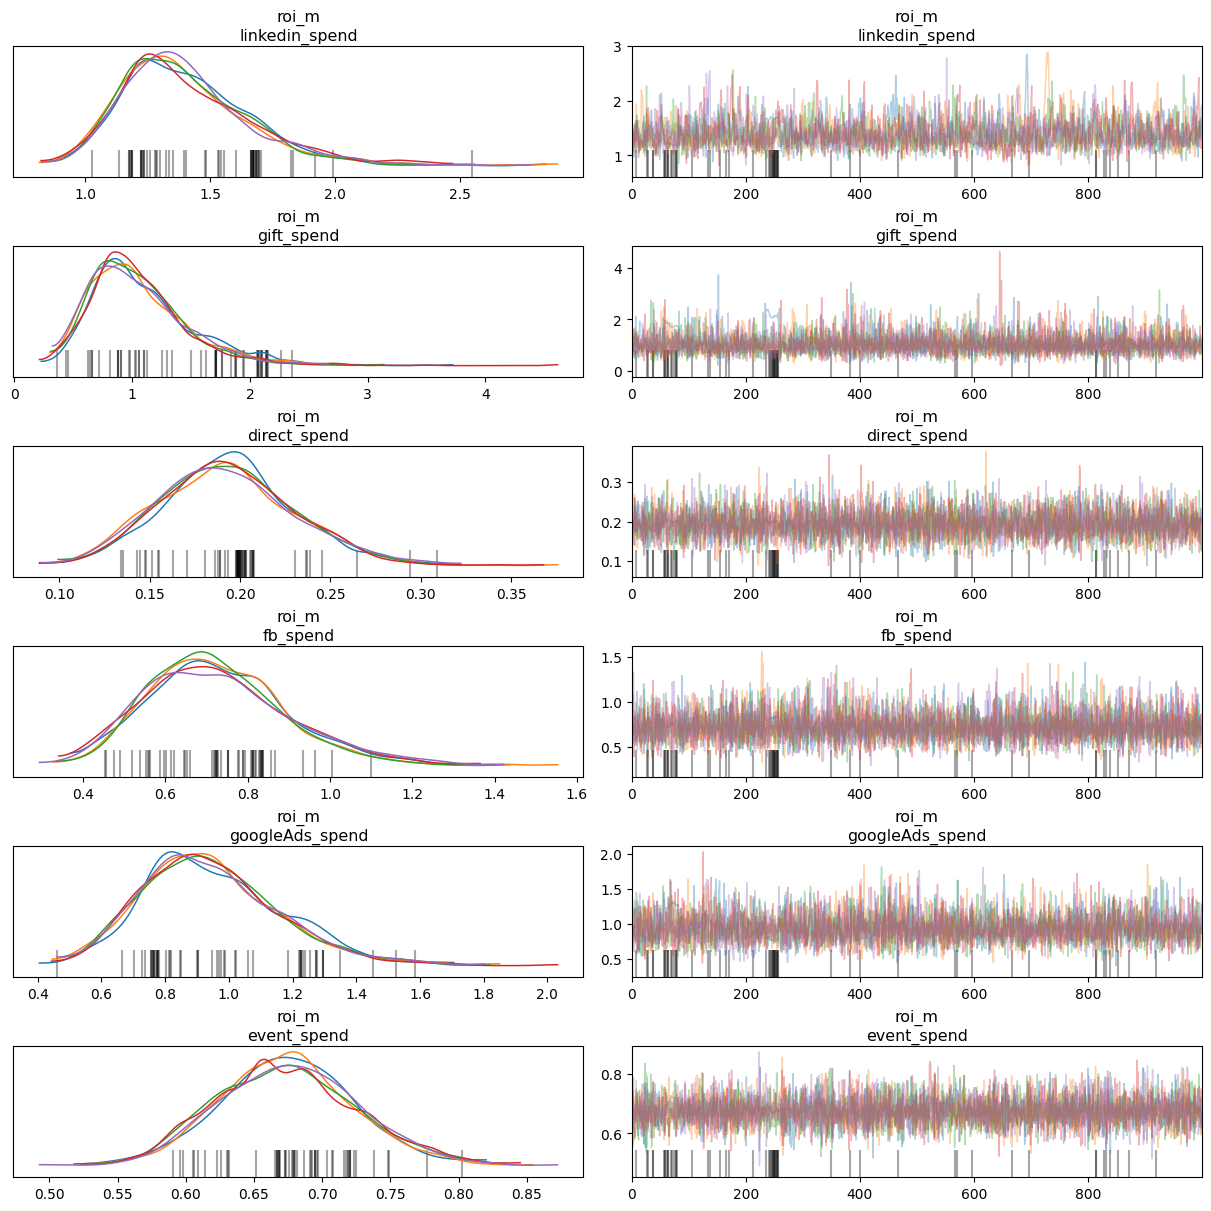

In [31]:
print(['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend',
       'googleAds_spend', 'event_spend'])
print(roi_m)
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [32]:
output_dict[model_iter] = {'model_diagnostics': visualizer.ModelDiagnostics(mmm),
'model_summary':visualizer.MediaSummary(mmm),
'media_effects': visualizer.MediaEffects(mmm),
'model_fit' : visualizer.ModelFit(mmm)}



/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:509: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


##  Model Fit Diagnostics

In [33]:
model_fit = output_dict[model_iter]['model_diagnostics']
model_fit.plot_rhat_boxplot()

alt.LayerChart(...)

In [34]:
model_fit = output_dict[model_iter]['model_fit']
model_fit.plot_model_fit()


alt.LayerChart(...)

In [35]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:509: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


,metric,geo_granularity,value
0,R_Squared,national,0.769131
1,MAPE,national,0.115154
2,wMAPE,national,0.109458


## Model Output

In [36]:
media_summary = output_dict[model_iter]['model_summary']
media_summary.summary_table()

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:894: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/analysis/visualizer.py:1603: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .aggregate(lambda g: f'{g[0]} ({g[1]}, {g[2]})')


,channel,distribution,impressions,% impressions,spend,% spend,cpm,incremental outcome,% contribution,roi,effectiveness,mroi,cpik
0,linkedin_spend,prior,"3,841,929",51%,"$3,841,929",51%,"$1,000","$5,422,446 ($3,196,055, $8,778,272)","20.0% (11.8%, 32.3%)","1.4 (0.8, 2.3)","1.41 (0.83, 2.28)","0.7 (0.3, 1.2)","$0.7 ($0.4, $1.2)"
1,linkedin_spend,posterior,"3,841,929",51%,"$3,841,929",51%,"$1,000","$5,390,312 ($4,047,896, $7,243,689)","73.0% (54.8%, 98.1%)","1.4 (1.1, 1.9)","1.40 (1.05, 1.89)","0.7 (0.6, 0.9)","$0.7 ($0.5, $0.9)"
2,gift_spend,prior,"89,413",1%,"$89,413",1%,"$1,000","$98,100 ($45,976, $168,038)","0.4% (0.2%, 0.6%)","1.1 (0.5, 1.9)","1.10 (0.51, 1.88)","0.5 (0.2, 1.0)","$1.0 ($0.5, $1.9)"
3,gift_spend,posterior,"89,413",1%,"$89,413",1%,"$1,000","$94,400 ($46,140, $165,163)","1.3% (0.6%, 2.2%)","1.1 (0.5, 1.8)","1.06 (0.52, 1.85)","0.5 (0.2, 0.9)","$1.0 ($0.5, $1.9)"
4,direct_spend,prior,"1,061,271",14%,"$1,061,271",14%,"$1,000","$1,191,274 ($569,335, $2,046,451)","4.4% (2.1%, 7.5%)","1.1 (0.5, 1.9)","1.12 (0.54, 1.93)","0.5 (0.2, 1.0)","$1.0 ($0.5, $1.9)"
5,direct_spend,posterior,"1,061,271",14%,"$1,061,271",14%,"$1,000","$204,819 ($142,699, $272,867)","2.8% (1.9%, 3.7%)","0.2 (0.1, 0.3)","0.19 (0.13, 0.26)","0.1 (0.0, 0.1)","$5.2 ($3.9, $7.4)"
6,fb_spend,prior,"679,517",9%,"$679,517",9%,"$1,000","$790,558 ($453,837, $1,283,845)","2.9% (1.7%, 4.7%)","1.2 (0.7, 1.9)","1.16 (0.67, 1.89)","0.5 (0.2, 1.1)","$0.9 ($0.5, $1.5)"
7,fb_spend,posterior,"679,517",9%,"$679,517",9%,"$1,000","$493,047 ($323,001, $702,222)","6.7% (4.4%, 9.5%)","0.7 (0.5, 1.0)","0.73 (0.48, 1.03)","0.3 (0.1, 0.6)","$1.4 ($1.0, $2.1)"
8,googleAds_spend,prior,"1,568,982",21%,"$1,568,982",21%,"$1,000","$1,798,025 ($1,139,188, $2,648,165)","6.6% (4.2%, 9.8%)","1.1 (0.7, 1.7)","1.15 (0.73, 1.69)","0.6 (0.2, 1.0)","$0.9 ($0.6, $1.4)"
9,googleAds_spend,posterior,"1,568,982",21%,"$1,568,982",21%,"$1,000","$1,481,650 ($992,413, $2,089,994)","20.1% (13.4%, 28.3%)","0.9 (0.6, 1.3)","0.94 (0.63, 1.33)","0.2 (0.1, 0.4)","$1.1 ($0.8, $1.6)"


In [37]:
# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()

alt.LayerChart(...)

In [38]:
media_effects = output_dict[model_iter]['media_effects']
media_effects.plot_response_curves()

alt.FacetChart(...)

In [39]:
media_effects.plot_adstock_decay()


alt.FacetChart(...)

# Model: 30P

## Specs

In [59]:
model_iter = 'scaled30_leads_mql_lesspharios_lessBDE_lessDC_plus_marketo'
print(model_iter)
response_var = models_dict[model_iter]['response_var']
all_vars = models_dict[model_iter]['df_variables']
organic = models_dict[model_iter]['organic_variables']
control = models_dict[model_iter]['control_variables']
roi_m = models_dict[model_iter]['roi_m_vars']
knots = models_dict[model_iter]['knots']
max_lag =  models_dict[model_iter]['max_lag']
sample_size_prior =  models_dict[model_iter]['sample_size_prior']
models_dict[model_iter]

model_1_data = raw_data[all_vars]
model_1_data['revenue_var'] = model_1_data[response_var]* 1000
data = model_1_data.copy()

scaled30_leads_mql_lesspharios_lessBDE_lessDC_plus_marketo


/var/folders/rt/jvrnppjd0lx_hpnwh05y501m0000gn/T/ipykernel_10472/3087737446.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_1_data['revenue_var'] = model_1_data[response_var]* 1000


In [60]:
response_var

'scaled30_leads_mql_lesspharios_lessBDE_lessDC'

##  Model Setup

In [61]:
# STEP 2: LOAD AND PREPARE YOUR DATA
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = organic

# Print and verify selected media channels
print("Selected Media Channels:", media)

# # Convert date column to datetime
# data['date_week'] = pd.to_datetime(data['date_week'])
data['date_week'] =  data['date']

# Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'revenue_var' in col.lower()
]


# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output, axis=1)
y = data[output[0]]  # if there is only one revenue column

# Inspect columns
data.head()

Selected Media Channels: ['linkedin_spend', 'gift_spend', 'direct_lessbulk_spend', 'fb_spend', 'googleAds_spend', 'event_spend']


,date,podcast_streams,linkedin_spend,gSearch_sessions,gift_spend,email_opened_cnt,direct_lessbulk_spend,fb_spend,googleAds_spend,event_spend,refined_ga4_ressions,event_hosted,webinar_occured,smoothed_MQL,scaled30_leads_mql_lesspharios_lessBDE_lessDC,revenue_var,date_week,t
0,2024-04-11,332.0,11063.50,1324.0,0.00,0.0,0.0,2169.57,6448.16,0.0,5092.0,0.0,0.0,61.0,83,83000,2024-04-11,0
1,2024-04-12,227.0,10985.40,1127.0,498.86,0.0,0.0,2189.92,4544.18,0.0,4061.0,0.0,0.0,60.0,96,96000,2024-04-12,1
2,2024-04-13,186.0,8826.29,504.0,0.00,0.0,0.0,2140.88,1676.13,0.0,2350.0,0.0,0.0,21.0,29,29000,2024-04-13,2
3,2024-04-14,120.0,7257.84,519.0,0.00,0.0,0.0,2404.75,2054.01,0.0,2426.0,0.0,0.0,30.0,45,45000,2024-04-14,3
4,2024-04-15,182.0,10275.43,1133.0,339.42,0.0,0.0,2307.37,5510.42,0.0,6368.0,0.0,0.0,116.0,133,133000,2024-04-15,4


In [62]:
cost_mapping, impressions_mapping = create_channel_mappings(media, media)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", impressions_mapping)

Cost Mapping: {'linkedin_spend': 'linkedin_spend', 'gift_spend': 'gift_spend', 'direct_lessbulk_spend': 'direct_lessbulk_spend', 'fb_spend': 'fb_spend', 'googleAds_spend': 'googleAds_spend', 'event_spend': 'event_spend'}
Impressions Mapping: {'linkedin_spend': 'linkedin_spend', 'gift_spend': 'gift_spend', 'direct_lessbulk_spend': 'direct_lessbulk_spend', 'fb_spend': 'fb_spend', 'googleAds_spend': 'googleAds_spend', 'event_spend': 'event_spend'}


In [63]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='date',
    kpi='revenue_var',   # make sure this matches your KPI column in the DataFrame
    controls=control,  # corrected name
    media=media,
    media_spend=media,
    organic_media=organic,  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type= 'revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/data/load.py:1023: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[geo_column_name] = self.df[geo_column_name].replace(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/data/load.py:201: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if (constants.GEO) not in self.dataset.dims.keys():
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/data/load.py:206: UserWarning: The `population` argument is ignored in a

In [64]:
build_media_channel_args = data_meridian.get_paid_media_channels_argument_builder()

# Assuming Channel1,...,Channel6 are all media channels.
roi_m = build_media_channel_args(
  linkedin_spend=roi_m['linkedin_spend'],
  gift_spend=roi_m['gift_spend'],
  direct_lessbulk_spend=roi_m['direct_lessbulk_spend'],
  fb_spend=roi_m['fb_spend'],
  googleAds_spend=roi_m['googleAds_spend'],
  event_spend=roi_m['event_spend'],
) # This creates a list of channel-ordered (mu, sigma) tuples.
roi_m_mu, roi_m_sigma = zip(*roi_m)

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_m_mu, roi_m_sigma, name=constants.ROI_M
    )
)
model_spec = spec.ModelSpec(prior=prior, knots=knots, max_lag=max_lag, adstock='delayed')
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/model.py:64: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
I0000 00:00:1752584720.449184  146623 service.cc:148] XLA service 0x17de2e1b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752584720.449216  146623 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1752584720.459296  146623 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


## Train model

In [65]:
mmm.sample_prior(sample_size_prior)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time


start_time = time.time()
# Remove progress_callback from the sample_posterior call
mmm.sample_posterior(
    n_chains=5,
    n_adapt=500,
    n_burnin=500,
    n_keep=1000,
    parallel_iterations=100,
    # progress_callback=update_progress  # Remove this line
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.4f} seconds")

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:902: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:902: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:902: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:902

Runtime: 150.8779 seconds


## ROI Plots

['linkedin_spend', 'gift_spend', 'direct_lessbulk_spend', 'fb_spend', 'googleAds_spend', 'event_spend']
[(0.3, 0.3), (0.01, 0.4), (0.01, 0.4), (0.1, 0.3), (0.1, 0.25), (0.01, 0.1)]


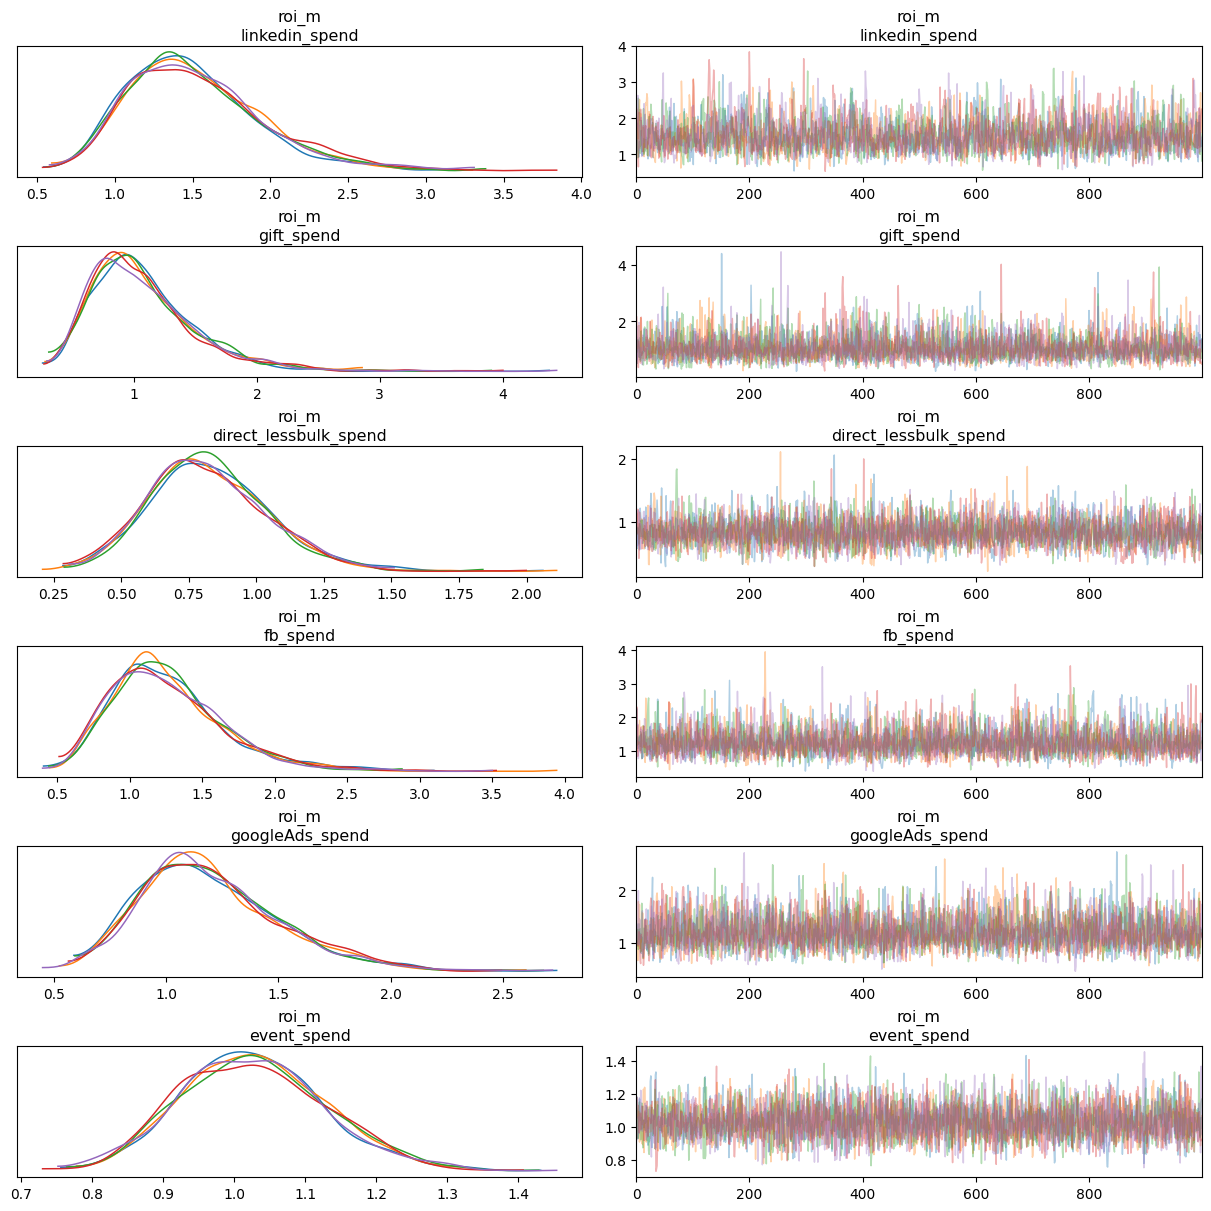

In [66]:
print(['linkedin_spend', 'gift_spend', 'direct_lessbulk_spend', 'fb_spend',
       'googleAds_spend', 'event_spend'])
print(roi_m)
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [67]:
output_dict[model_iter] = {'model_diagnostics': visualizer.ModelDiagnostics(mmm),
'model_summary':visualizer.MediaSummary(mmm),
'media_effects': visualizer.MediaEffects(mmm),
'model_fit' : visualizer.ModelFit(mmm)}



/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:509: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


##  Model Fit Diagnostics

In [68]:
model_fit = output_dict[model_iter]['model_diagnostics']
model_fit.plot_rhat_boxplot()

alt.LayerChart(...)

In [69]:
model_fit = output_dict[model_iter]['model_fit']
model_fit.plot_model_fit()


alt.LayerChart(...)

In [70]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:509: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


,metric,geo_granularity,value
0,R_Squared,national,0.597796
1,MAPE,national,0.199178
2,wMAPE,national,0.189070


## Model Output

In [71]:
media_summary = output_dict[model_iter]['model_summary']
media_summary.summary_table()

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:894: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/analysis/visualizer.py:1603: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .aggregate(lambda g: f'{g[0]} ({g[1]}, {g[2]})')


,channel,distribution,impressions,% impressions,spend,% spend,cpm,incremental outcome,% contribution,roi,effectiveness,mroi,cpik
0,linkedin_spend,prior,"3,841,929",53%,"$3,841,929",53%,"$1,000","$5,450,306 ($3,141,928, $8,559,178)","5.6% (3.2%, 8.8%)","1.4 (0.8, 2.2)","1.42 (0.82, 2.23)","0.7 (0.2, 1.2)","$0.7 ($0.4, $1.2)"
1,linkedin_spend,posterior,"3,841,929",53%,"$3,841,929",53%,"$1,000","$5,847,026 ($3,540,084, $9,032,523)","20.9% (12.7%, 32.3%)","1.5 (0.9, 2.4)","1.52 (0.92, 2.35)","0.9 (0.4, 1.4)","$0.7 ($0.4, $1.1)"
2,gift_spend,prior,"89,413",1%,"$89,413",1%,"$1,000","$96,283 ($44,338, $163,768)","0.1% (0.0%, 0.2%)","1.1 (0.5, 1.8)","1.08 (0.50, 1.83)","0.5 (0.2, 0.9)","$1.0 ($0.5, $2.0)"
3,gift_spend,posterior,"89,413",1%,"$89,413",1%,"$1,000","$95,577 ($46,855, $168,525)","0.3% (0.2%, 0.6%)","1.1 (0.5, 1.9)","1.07 (0.52, 1.88)","0.5 (0.2, 0.9)","$1.0 ($0.5, $1.9)"
4,direct_lessbulk_spend,prior,"779,471",11%,"$779,471",11%,"$1,000","$874,120 ($438,748, $1,512,963)","0.9% (0.4%, 1.5%)","1.1 (0.6, 1.9)","1.12 (0.56, 1.94)","0.6 (0.2, 1.1)","$1.0 ($0.5, $1.8)"
5,direct_lessbulk_spend,posterior,"779,471",11%,"$779,471",11%,"$1,000","$641,911 ($380,804, $941,836)","2.3% (1.4%, 3.4%)","0.8 (0.5, 1.2)","0.82 (0.49, 1.21)","0.4 (0.2, 0.7)","$1.2 ($0.8, $2.0)"
6,fb_spend,prior,"679,517",9%,"$679,517",9%,"$1,000","$804,540 ($491,011, $1,259,700)","0.8% (0.5%, 1.3%)","1.2 (0.7, 1.9)","1.18 (0.72, 1.85)","0.6 (0.2, 1.0)","$0.9 ($0.5, $1.4)"
7,fb_spend,posterior,"679,517",9%,"$679,517",9%,"$1,000","$856,444 ($497,107, $1,350,158)","3.1% (1.8%, 4.8%)","1.3 (0.7, 2.0)","1.26 (0.73, 1.99)","0.6 (0.2, 1.1)","$0.8 ($0.5, $1.4)"
8,googleAds_spend,prior,"1,568,982",22%,"$1,568,982",22%,"$1,000","$1,786,583 ($1,149,032, $2,653,256)","1.8% (1.2%, 2.7%)","1.1 (0.7, 1.7)","1.14 (0.73, 1.69)","0.5 (0.2, 0.9)","$0.9 ($0.6, $1.4)"
9,googleAds_spend,posterior,"1,568,982",22%,"$1,568,982",22%,"$1,000","$1,883,177 ($1,202,938, $2,812,787)","6.7% (4.3%, 10.1%)","1.2 (0.8, 1.8)","1.20 (0.77, 1.79)","0.6 (0.3, 1.1)","$0.9 ($0.6, $1.3)"


In [72]:
# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()

alt.LayerChart(...)

In [73]:
media_effects = output_dict[model_iter]['media_effects']
media_effects.plot_response_curves()

alt.FacetChart(...)

In [74]:
media_effects.plot_adstock_decay()


alt.FacetChart(...)

# Model: 30P

## Specs

In [ ]:
model_iter = all_models_list[2]
print(model_iter)
response_var = models_dict[model_iter]['response_var']
all_vars = models_dict[model_iter]['df_variables']
organic = models_dict[model_iter]['organic_variables']
control = models_dict[model_iter]['control_variables']
roi_m = models_dict[model_iter]['roi_m_vars']
knots = models_dict[model_iter]['knots']
max_lag =  models_dict[model_iter]['max_lag']
sample_size_prior =  models_dict[model_iter]['sample_size_prior']
models_dict[model_iter]

model_1_data = raw_data[all_vars]
model_1_data['revenue_var'] = model_1_data[response_var]* 1000
data = model_1_data.copy()

In [ ]:
response_var

##  Model Setup

In [ ]:
# STEP 2: LOAD AND PREPARE YOUR DATA
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = organic

# Print and verify selected media channels
print("Selected Media Channels:", media)

# # Convert date column to datetime
# data['date_week'] = pd.to_datetime(data['date_week'])
data['date_week'] =  data['date']

# Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'revenue_var' in col.lower()
]


# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output, axis=1)
y = data[output[0]]  # if there is only one revenue column

# Inspect columns
data.head()

In [ ]:
cost_mapping, impressions_mapping = create_channel_mappings(media, media)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", impressions_mapping)

In [ ]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='date',
    kpi='revenue_var',   # make sure this matches your KPI column in the DataFrame
    controls=control,  # corrected name
    media=media,
    media_spend=media,
    organic_media=organic,  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type= 'revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

In [ ]:
build_media_channel_args = data_meridian.get_paid_media_channels_argument_builder()

# Assuming Channel1,...,Channel6 are all media channels.
roi_m = build_media_channel_args(
  linkedin_spend=roi_m['linkedin_spend'],
  gift_spend=roi_m['gift_spend'],
  direct_lessbulk_spend=roi_m['direct_lessbulk_spend'],
  fb_spend=roi_m['fb_spend'],
  googleAds_spend=roi_m['googleAds_spend'],
  event_spend=roi_m['event_spend'],
) # This creates a list of channel-ordered (mu, sigma) tuples.
roi_m_mu, roi_m_sigma = zip(*roi_m)

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_m_mu, roi_m_sigma, name=constants.ROI_M
    )
)
model_spec = spec.ModelSpec(prior=prior, knots=knots, max_lag=max_lag)
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)

## Train model

In [ ]:
mmm.sample_prior(sample_size_prior)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time


start_time = time.time()
# Remove progress_callback from the sample_posterior call
mmm.sample_posterior(
    n_chains=5,
    n_adapt=500,
    n_burnin=500,
    n_keep=1000,
    parallel_iterations=100,
    # progress_callback=update_progress  # Remove this line
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.4f} seconds")

## ROI Plots

In [ ]:
print(['linkedin_spend', 'gift_spend', 'direct_lesspharios_spend', 'fb_spend',
       'googleAds_spend', 'event_spend'])
print(roi_m)
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [ ]:
output_dict[model_iter] = {'model_diagnostics': visualizer.ModelDiagnostics(mmm),
'model_summary':visualizer.MediaSummary(mmm),
'media_effects': visualizer.MediaEffects(mmm),
'model_fit' : visualizer.ModelFit(mmm)}



##  Model Fit Diagnostics

In [ ]:
model_fit = output_dict[model_iter]['model_diagnostics']
model_fit.plot_rhat_boxplot()

In [ ]:
model_fit = output_dict[model_iter]['model_fit']
model_fit.plot_model_fit()


In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

## Model Output

In [ ]:
media_summary = output_dict[model_iter]['model_summary']
media_summary.summary_table()

In [ ]:
# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()

In [ ]:
media_effects = output_dict[model_iter]['media_effects']
media_effects.plot_response_curves()

In [ ]:
media_effects.plot_adstock_decay()


# Model: 20P - Pharios -BDE 

## Specs

In [ ]:
model_iter = all_models_list[3]
print(model_iter)
response_var = models_dict[model_iter]['response_var']
all_vars = models_dict[model_iter]['df_variables']
organic = models_dict[model_iter]['organic_variables']
control = models_dict[model_iter]['control_variables']
roi_m = models_dict[model_iter]['roi_m_vars']
knots = models_dict[model_iter]['knots']
max_lag =  models_dict[model_iter]['max_lag']
sample_size_prior =  models_dict[model_iter]['sample_size_prior']
models_dict[model_iter]

model_1_data = raw_data[all_vars]
model_1_data['revenue_var'] = model_1_data[response_var]* 1000
data = model_1_data.copy()

In [ ]:
response_var

##  Model Setup

In [ ]:
# STEP 2: LOAD AND PREPARE YOUR DATA
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = organic

# Print and verify selected media channels
print("Selected Media Channels:", media)

# # Convert date column to datetime
# data['date_week'] = pd.to_datetime(data['date_week'])
data['date_week'] =  data['date']

# Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'revenue_var' in col.lower()
]


# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output, axis=1)
y = data[output[0]]  # if there is only one revenue column

# Inspect columns
data.head()

In [ ]:
cost_mapping, impressions_mapping = create_channel_mappings(media, media)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", impressions_mapping)

In [ ]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='date',
    kpi='revenue_var',   # make sure this matches your KPI column in the DataFrame
    controls=control,  # corrected name
    media=media,
    media_spend=media,
    organic_media=organic,  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type= 'revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

In [ ]:
build_media_channel_args = data_meridian.get_paid_media_channels_argument_builder()

# Assuming Channel1,...,Channel6 are all media channels.
roi_m = build_media_channel_args(
  linkedin_spend=roi_m['linkedin_spend'],
  gift_spend=roi_m['gift_spend'],
  direct_lesspharios_spend=roi_m['direct_lesspharios_spend'],
  fb_spend=roi_m['fb_spend'],
  googleAds_spend=roi_m['googleAds_spend'],
  event_spend=roi_m['event_spend'],
) # This creates a list of channel-ordered (mu, sigma) tuples.
roi_m_mu, roi_m_sigma = zip(*roi_m)

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_m_mu, roi_m_sigma, name=constants.ROI_M
    )
)
model_spec = spec.ModelSpec(prior=prior, knots=knots, max_lag=max_lag)
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)

## Train model

In [ ]:
mmm.sample_prior(sample_size_prior)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time


start_time = time.time()
# Remove progress_callback from the sample_posterior call
mmm.sample_posterior(
    n_chains=5,
    n_adapt=500,
    n_burnin=500,
    n_keep=1000,
    parallel_iterations=100,
    # progress_callback=update_progress  # Remove this line
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.4f} seconds")

## ROI Plots

In [ ]:
print(['linkedin_spend', 'gift_spend', 'direct_lesspharios_spend', 'fb_spend',
       'googleAds_spend', 'event_spend'])
print(roi_m)
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [ ]:
output_dict[model_iter] = {'model_diagnostics': visualizer.ModelDiagnostics(mmm),
'model_summary':visualizer.MediaSummary(mmm),
'media_effects': visualizer.MediaEffects(mmm),
'model_fit' : visualizer.ModelFit(mmm)}



##  Model Fit Diagnostics

In [ ]:
model_fit = output_dict[model_iter]['model_diagnostics']
model_fit.plot_rhat_boxplot()

In [ ]:
model_fit = output_dict[model_iter]['model_fit']
model_fit.plot_model_fit()


In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

## Model Output

In [ ]:
media_summary = output_dict[model_iter]['model_summary']
media_summary.summary_table()

In [ ]:
# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()

In [ ]:
media_effects = output_dict[model_iter]['media_effects']
media_effects.plot_response_curves()

In [ ]:
media_effects.plot_adstock_decay()


# Model: 20 P - Pharios - BDE - DC260

## Specs

In [ ]:
model_iter = all_models_list[4]
print(model_iter)
response_var = models_dict[model_iter]['response_var']
all_vars = models_dict[model_iter]['df_variables']
organic = models_dict[model_iter]['organic_variables']
control = models_dict[model_iter]['control_variables']
roi_m = models_dict[model_iter]['roi_m_vars']
knots = models_dict[model_iter]['knots']
max_lag =  models_dict[model_iter]['max_lag']
sample_size_prior =  models_dict[model_iter]['sample_size_prior']
models_dict[model_iter]

model_1_data = raw_data[all_vars]
model_1_data['revenue_var'] = model_1_data[response_var]* 1000
data = model_1_data.copy()

In [ ]:
response_var

##  Model Setup

In [ ]:
# STEP 2: LOAD AND PREPARE YOUR DATA
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = organic

# Print and verify selected media channels
print("Selected Media Channels:", media)

# # Convert date column to datetime
# data['date_week'] = pd.to_datetime(data['date_week'])
data['date_week'] =  data['date']

# Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'revenue_var' in col.lower()
]


# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output, axis=1)
y = data[output[0]]  # if there is only one revenue column

# Inspect columns
data.head()

In [ ]:
cost_mapping, impressions_mapping = create_channel_mappings(media, media)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", impressions_mapping)

In [ ]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='date',
    kpi='revenue_var',   # make sure this matches your KPI column in the DataFrame
    controls=control,  # corrected name
    media=media,
    media_spend=media,
    organic_media=organic,  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type= 'revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

In [ ]:
build_media_channel_args = data_meridian.get_paid_media_channels_argument_builder()

# Assuming Channel1,...,Channel6 are all media channels.
roi_m = build_media_channel_args(
  linkedin_spend=roi_m['linkedin_spend'],
  gift_spend=roi_m['gift_spend'],
  direct_lessbulk_spend=roi_m['direct_lessbulk_spend'],
  fb_spend=roi_m['fb_spend'],
  googleAds_spend=roi_m['googleAds_spend'],
  event_spend=roi_m['event_spend'],
) # This creates a list of channel-ordered (mu, sigma) tuples.
roi_m_mu, roi_m_sigma = zip(*roi_m)

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_m_mu, roi_m_sigma, name=constants.ROI_M
    )
)
model_spec = spec.ModelSpec(prior=prior, knots=knots, max_lag=max_lag)
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)

## Train model

In [ ]:
mmm.sample_prior(sample_size_prior)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time


start_time = time.time()
# Remove progress_callback from the sample_posterior call
mmm.sample_posterior(
    n_chains=5,
    n_adapt=500,
    n_burnin=500,
    n_keep=1000,
    parallel_iterations=100,
    # progress_callback=update_progress  # Remove this line
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.4f} seconds")

## ROI Plots

In [ ]:
print(['linkedin_spend', 'gift_spend', 'direct_lessbulk_spend', 'fb_spend',
       'googleAds_spend', 'event_spend'])
print(roi_m)
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [ ]:
output_dict[model_iter] = {'model_diagnostics': visualizer.ModelDiagnostics(mmm),
'model_summary':visualizer.MediaSummary(mmm),
'media_effects': visualizer.MediaEffects(mmm),
'model_fit' : visualizer.ModelFit(mmm)}



##  Model Fit Diagnostics

In [ ]:
model_fit = output_dict[model_iter]['model_diagnostics']
model_fit.plot_rhat_boxplot()

In [ ]:
model_fit = output_dict[model_iter]['model_fit']
model_fit.plot_model_fit()


In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

## Model Output

In [ ]:
media_summary = output_dict[model_iter]['model_summary']
media_summary.summary_table()

In [ ]:
# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()

In [ ]:
media_effects = output_dict[model_iter]['media_effects']
media_effects.plot_response_curves()

## Model Output

In [ ]:
media_summary = output_dict[model_iter]['model_summary']
media_summary.summary_table()

In [ ]:
# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()

In [ ]:
media_effects = output_dict[model_iter]['media_effects']
media_effects.plot_response_curves()

In [ ]:
media_effects.plot_adstock_decay()


In [ ]:
models_dict

In [ ]:
output_dict.keys()

# Model: 30 P - Pharios - BDE - DC260 + Marketo Adds

## Specs

In [ ]:
model_iter = all_models_list[6]
print(model_iter)
response_var = models_dict[model_iter]['response_var']
all_vars = models_dict[model_iter]['df_variables']
organic = models_dict[model_iter]['organic_variables']
control = models_dict[model_iter]['control_variables']
roi_m = models_dict[model_iter]['roi_m_vars']
knots = models_dict[model_iter]['knots']
max_lag =  models_dict[model_iter]['max_lag']
sample_size_prior =  models_dict[model_iter]['sample_size_prior']
models_dict[model_iter]

model_1_data = raw_data[all_vars]
model_1_data['revenue_var'] = model_1_data[response_var]* 1000
data = model_1_data.copy()

##  Model Setup

In [ ]:
# STEP 2: LOAD AND PREPARE YOUR DATA
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = organic

# Print and verify selected media channels
print("Selected Media Channels:", media)

# # Convert date column to datetime
# data['date_week'] = pd.to_datetime(data['date_week'])
data['date_week'] =  data['date']

# Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'revenue_var' in col.lower()
]


# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output, axis=1)
y = data[output[0]]  # if there is only one revenue column

# Inspect columns
data.head()

In [ ]:
cost_mapping, impressions_mapping = create_channel_mappings(media, media)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", impressions_mapping)

In [ ]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='date',
    kpi='revenue_var',   # make sure this matches your KPI column in the DataFrame
    controls=control,  # corrected name
    media=media,
    media_spend=media,
    organic_media=organic,  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type= 'revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/data/load.py:896: UserWarning: The `population` argument is ignored in a nationally aggregated model. It will be reset to [1, 1, ..., 1]
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/data/load.py:1033: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[geo_column_name] = self.df[geo_column_name].replace(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/data/load.py:206: UserWarning: The `population` argument is ignored in a nationally aggregated model. It will be reset to [1]
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/meridian/lib/python3.11/site-packages/meridian/data/inpu

ValueError: Array 'population' should have name 'controls'

In [ ]:
build_media_channel_args = data_meridian.get_paid_media_channels_argument_builder()

# Assuming Channel1,...,Channel6 are all media channels.
roi_m = build_media_channel_args(
  linkedin_spend=roi_m['linkedin_spend'],
  gift_spend=roi_m['gift_spend'],
  direct_lessbulk_spend=roi_m['direct_lessbulk_spend'],
  fb_spend=roi_m['fb_spend'],
  googleAds_spend=roi_m['googleAds_spend'],
  event_spend=roi_m['event_spend'],
) # This creates a list of channel-ordered (mu, sigma) tuples.
roi_m_mu, roi_m_sigma = zip(*roi_m)

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_m_mu, roi_m_sigma, name=constants.ROI_M
    )
)
model_spec = spec.ModelSpec(prior=prior, knots=knots, max_lag=max_lag)
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)

## Train model

In [ ]:
mmm.sample_prior(sample_size_prior)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time


start_time = time.time()
# Remove progress_callback from the sample_posterior call
mmm.sample_posterior(
    n_chains=5,
    n_adapt=500,
    n_burnin=500,
    n_keep=1000,
    parallel_iterations=100,
    # progress_callback=update_progress  # Remove this line
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.4f} seconds")

In [ ]:
output

## ROI Plots

In [ ]:
print(['linkedin_spend', 'gift_spend', 'direct_lessbulk_spend', 'fb_spend',
       'googleAds_spend', 'event_spend'])
print(roi_m)
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [ ]:
output_dict[model_iter] = {'model_diagnostics': visualizer.ModelDiagnostics(mmm),
'model_summary':visualizer.MediaSummary(mmm),
'media_effects': visualizer.MediaEffects(mmm),
'model_fit' : visualizer.ModelFit(mmm)}



##  Model Fit Diagnostics

In [ ]:
model_fit = output_dict[model_iter]['model_diagnostics']
model_fit.plot_rhat_boxplot()

In [ ]:
model_fit = output_dict[model_iter]['model_fit']
model_fit.plot_model_fit()


In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

## Model Output

In [ ]:
media_summary = output_dict[model_iter]['model_summary']
media_summary.summary_table()

In [ ]:
# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()

In [ ]:
media_effects = output_dict[model_iter]['media_effects']
media_effects.plot_response_curves()

## Model Output

In [ ]:
media_summary = output_dict[model_iter]['model_summary']
media_summary.summary_table()

In [ ]:
# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()

In [ ]:
media_effects = output_dict[model_iter]['media_effects']
media_effects.plot_response_curves()

In [ ]:
media_effects.plot_adstock_decay()


In [ ]:
# Get last 4 weeks of data
last_4_weeks = data['date_week'][-4:].values

print("Last 4 weeks:")
for week in last_4_weeks:
    print(week)

# Calculate total media spend in last 4 weeks
last_4_weeks_spend = data[media].iloc[-4:]

print("\nTotal media spend in last 4 weeks:")
for week, spend in zip(last_4_weeks, last_4_weeks_spend):
    print(week,spend)

print(last_4_weeks_spend.sum().sum())

print(len(media))

In [ ]:
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize(
      selected_times=('2025-03-08', '2025-03-11'),
      budget=34000,
)

In [ ]:
optimization_results.nonoptimized_data

In [ ]:
filepath = 'data/usaonlyanalysis'
optimization_results.output_optimization_summary('optimization_output.html', filepath)

In [ ]:
IPython.display.HTML(filename='data/usaonlyanalysis/optimization_output.html')

In [ ]:
output_dict.keys()

In [ ]:
models_dev = list(output_dict.keys())
for model_case in modmodels_devels[3:]:
    print(model_case)
    model_diagnostics = output_dict[model_case]['model_diagnostics']
    print(model_diagnostics.predictive_accuracy_table())

In [ ]:
model_diagnostics = output_dict['scaled_linkedin_leads_mql']['model_diagnostics']
model_diagnostics.predictive_accuracy_table()

In [ ]:
model_diagnostics = visualizer.
)